# Functions

In [ ]:
import pandas as pd
import numpy as np
import joblib
from sklearn.metrics import root_mean_squared_error, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import statsmodels.api as sm
from typing import Union, List

In [ ]:
predictions_basic = joblib.load('../data/predictions/predictions_basic.pkl')
predictions_logs = joblib.load('../data/predictions/predictions_logs.pkl')
predictions_group_agg = joblib.load('../data/predictions/predictions_group_agg.pkl')

# RMSE by groups

In [ ]:
def load_test_data(spec_name: str) -> pd.DataFrame:
    """
    Load and combine test data for a given specification.
    
    Parameters
    ----------
    spec_name : str
        Name of the specification (e.g., 'sample_logs', etc.)
        Note: Should not be 'main' as that's handled separately.
        
    Returns
    -------
    pd.DataFrame
        Combined DataFrame containing:
        - True values (y_true)
        - Predicted values (y_pred)
        - Confidence intervals (y_lower, y_upper if available)
        - All features from X_test
    """

    # Load test data
    X_test = pd.read_pickle(f'../data/processed/X_pp_test_{spec_name}.pkl')
    y_test = pd.read_pickle(f'../data/processed/y_test_{spec_name}.pkl')
    X_test = X_test.reset_index(drop=True)
    
    # Load predictions
    predictions = joblib.load(f'../data/predictions/predictions_{spec_name}.pkl')
    y_test_pred = predictions['y_ensb_test']
    y_test_pred = y_test_pred.reset_index(drop=True)
    
    # Format true values
    y_test = pd.DataFrame(y_test)
    y_test = y_test.rename(columns={'fgcp': 'y_true'})
    y_test = y_test.reset_index(drop=True)
    
    # Format predictions
    y_test_pred = y_test_pred.rename(columns={'y': 'y_pred'})
    
    # Combine all data
    df_test = pd.concat([y_test, y_test_pred, X_test], axis=1)
    
    return df_test

In [73]:
df_test = load_test_data('basic')

In [ ]:

def calculate_rmse_by_groups(df: pd.DataFrame, 
                           group_col: str, 
                           y_true_col: str = 'y_true', 
                           y_pred_col: str = 'y_pred') -> pd.DataFrame:
    """
    Calculate RMSE for each group or combination of groups.
    
    Args:
        df (pd.DataFrame): DataFrame containing the data
        groups (str or List[str]): Column name(s) to group by
        y_true_col (str): Name of column containing true values
        y_pred_col (str): Name of column containing predicted values
    
    Returns:
        pd.DataFrame: DataFrame with RMSE and sample counts for each group
    """

    # Function to calculate RMSE for a group
    def rmse_func(group):
        return np.sqrt(mean_squared_error(
            group[y_true_col].values,
            group[y_pred_col].values
        ))
    
    # Calculate RMSE and sample size for each group
    results = []
    
    # Group by the specified columns and calculate metrics
    grouped = df.groupby(group_col)
    
    # Calculate RMSE and counts
    rmse_values = grouped.apply(rmse_func)
    counts = grouped.size()
    
    # Combine into a DataFrame
    results_df = pd.DataFrame({
        'rmse': rmse_values,
        'count': counts
    }).reset_index()
    
    # Add overall RMSE for reference
    overall_rmse = np.sqrt(mean_squared_error(
        df[y_true_col].values,
        df[y_pred_col].values
    ))
    
    # print(f"Overall RMSE: {overall_rmse:.4f}")
    results_df = results_df.T
    results_df.columns = results_df.columns.astype(str)
    results_df.columns = [group_col + '_' + col for col in results_df.columns]
    results_df = results_df.reset_index(drop=True)

    # Drop first row
    results_df = results_df.iloc[1:]
    
    return round(results_df, 3)

In [75]:
rmse_by_country = calculate_rmse_by_groups(df_test, 'country')
rmse_by_gender = calculate_rmse_by_groups(df_test, 'ragender_2_0')
rmse_by_raeducl = calculate_rmse_by_groups(df_test, 'raeducl')

/var/folders/k2/l43pc0gj6311hvl_9yxc3kzc0000gn/T/ipykernel_81863/1695753277.py:37: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  rmse_values = grouped.apply(rmse_func)
/var/folders/k2/l43pc0gj6311hvl_9yxc3kzc0000gn/T/ipykernel_81863/1695753277.py:37: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  rmse_values = grouped.apply(rmse_func)
/var/folders/k2/l43pc0gj6311hvl_9yxc3kzc0000gn/T/ipykernel_81863/169575327

In [76]:
rmse_by_groups = pd.concat([rmse_by_country, rmse_by_gender, rmse_by_raeducl], axis=1)

In [77]:
rmse_by_groups

,country_0,country_1,country_2,country_3,ragender_2_0_0,ragender_2_0_1,raeducl_0,raeducl_1,raeducl_2
1,0.689,0.677,0.773,0.615,0.689,0.666,0.698,0.682,0.547
2,819.000,407.000,266.000,660.000,944.000,1208.000,1180.000,688.000,258.000


In [ ]:
rmse_by_groups.to_excel('rmse_by_groups.xlsx')

# RMSE for each specification and model

In [ ]:
# Load true values
y_test_basic = pd.read_pickle('../data/processed/y_test_basic.pkl')

# More concise version
table_rmse_spec_model = []

for spec in ['basic', 'logs', 'group_agg']:
    predictions = joblib.load(f'../data/predictions/predictions_{spec}.pkl')
    
    for model in ['catb', 'lgbm', 'xgbm', 'ensb']:
        # Get model predictions
        key = 'y_ensb_test' if model == 'ensb' else f'y_{model}_test'
        y_pred = predictions[key].copy()
        y_pred['y_true'] = y_test_basic.values
        
        # Calculate and store RMSE
        rmse = root_mean_squared_error(y_pred["y_true"], y_pred["y"])
        table_rmse_spec_model.append({'spec': spec, 'model': model, 'rmse': rmse})

# Create dataframe
table_rmse_spec_model = pd.DataFrame(table_rmse_spec_model)

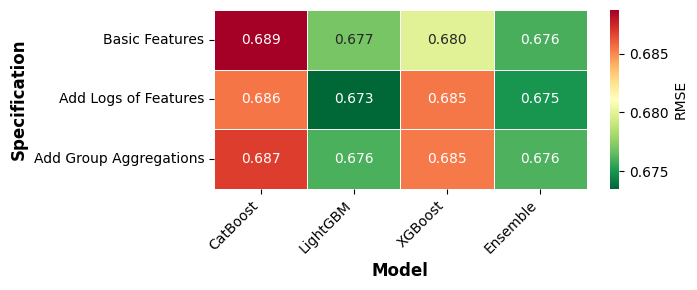

In [ ]:
# Create pivot table for heatmap
results_pivot = table_rmse_spec_model.pivot(index='spec', columns='model', values='rmse')

# Reorder columns (models) in the desired order
model_order = ['catb', 'lgbm', 'xgbm', 'ensb'] 
results_pivot = results_pivot[model_order]

# Create proper names mapping
model_names = {
    'catb': 'CatBoost',
    'lgbm': 'LightGBM', 
    'xgbm': 'XGBoost',
    'ensb': 'Ensemble'
}

spec_names = {
    'basic': 'Basic Features',
    'logs': 'Add Logs of Features',
    'group_agg': 'Add Group Aggregations'
}

# Rename columns and index
results_pivot.columns = [model_names[col] for col in results_pivot.columns]
results_pivot.index = [spec_names[idx] for idx in results_pivot.index]

# Create heatmap
plt.figure(figsize=(7, 3))
sns.heatmap(results_pivot, 
            annot=True,           # Show values in cells
            fmt='.3f',            # Format to 3 decimal places
            cmap='RdYlGn_r',      # Red-Yellow-Green (red=high, green=low)
            cbar_kws={'label': 'RMSE'},
            linewidths=0.5)       # Add grid lines

plt.xlabel('Model', fontsize=12, fontweight='bold')
plt.ylabel('Specification', fontsize=12, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Removing % of features/obs

In [ ]:
# More concise version
table_rmse_spec_model = []

for spec in ['reduced_obs_10pct', 'reduced_obs_30pct', 'reduced_obs_50pct', 'reduced_obs_70pct', 'reduced_obs_90pct']:
    predictions = joblib.load(f'../data/predictions/predictions_{spec}.pkl')
    
    for model in ['catb', 'lgbm', 'xgbm','ensb']: # 'lasso'
        # Get model predictions
        key = 'y_ensb_test' if model == 'ensb' else f'y_{model}_test'
        y_test = pd.read_pickle(f'../data/processed/y_test_{spec}.pkl')
        y_pred = predictions[key].copy()
        y_pred['y_true'] = y_test.values
        
        # Calculate and store RMSE
        rmse = root_mean_squared_error(y_pred["y_true"], y_pred["y"])
        table_rmse_spec_model.append({'spec': spec, 'model': model, 'rmse': rmse})

# Create dataframe
table_rmse_spec_model = pd.DataFrame(table_rmse_spec_model)

# Optional: Pivot table for better visualization
rmse_pivot_reduced_obs = table_rmse_spec_model.pivot(index='spec', columns='model', values='rmse')

rmse_pivot_reduced_obs

model,catb,ensb,lgbm,xgbm
spec,,,,
reduced_obs_10pct,0.672256,0.662958,0.669348,0.671327
reduced_obs_30pct,0.691736,0.675083,0.676099,0.683308
reduced_obs_50pct,0.690390,0.681717,0.684883,0.697335
reduced_obs_70pct,0.695921,0.676766,0.676793,0.681743
reduced_obs_90pct,0.708135,0.704570,0.727904,0.713120


In [ ]:
# More concise version
table_rmse_spec_model = []

for spec in ['reduced_features_10pct', 'reduced_features_30pct', 'reduced_features_50pct', 'reduced_features_70pct', 'reduced_features_90pct']:
    predictions = joblib.load(f'../data/predictions/predictions_{spec}.pkl')
    
    for model in ['catb', 'lgbm', 'xgbm','ensb']: # 'lasso'
        # Get model predictions
        key = 'y_ensb_test' if model == 'ensb' else f'y_{model}_test'
        y_test = pd.read_pickle(f'../data/processed/y_test_{spec}.pkl')
        y_pred = predictions[key].copy()
        y_pred['y_true'] = y_test.values
        
        # Calculate and store RMSE
        rmse = root_mean_squared_error(y_pred["y_true"], y_pred["y"])
        table_rmse_spec_model.append({'spec': spec, 'model': model, 'rmse': rmse})

# Create dataframe
table_rmse_spec_model = pd.DataFrame(table_rmse_spec_model)

# Optional: Pivot table for better visualization
rmse_pivot_reduced_features = table_rmse_spec_model.pivot(index='spec', columns='model', values='rmse')

rmse_pivot_reduced_features

model,catb,ensb,lgbm,xgbm
spec,,,,
reduced_features_10pct,0.696315,0.684933,0.682509,0.692745
reduced_features_30pct,0.703188,0.688682,0.685568,0.694172
reduced_features_50pct,0.699570,0.689541,0.688145,0.697809
reduced_features_70pct,0.782204,0.769813,0.771776,0.772530
reduced_features_90pct,0.838298,0.834244,0.837942,0.835198


In [67]:
rmse_reduced = pd.DataFrame({'Features':rmse_pivot_reduced_features['ensb'].values,
                             'Observations':rmse_pivot_reduced_obs['ensb'].values})
rmse_reduced.index = ['Removed 10%', 'Removed 30%', 'Removed 50%', 'Removed 70%', 'Removed 90%']

In [72]:
# Print rmse_reduced dataframe with .3f
rmse_reduced.round(3).to_excel('rmse_reduced.xlsx')

# Comparison of RMSE for each country with different cross-val

In [ ]:
# Define countries
list_countries = ['india', 'uk', 'us', 'mexico']

# Define countries with proper names
country_names = {
    'india': 'India',
    'uk': 'UK',
    'us': 'US',
    'mexico': 'Mexico'
}

cv_types = {
    'only_country': 'Single Country',
    'partial_holdout': 'All + Partial Country',
    'full_holdout': 'All Others Only'
}

# Initialize list to store results
results = []

# Process each country
for country in list_countries:
    
    # Load test data
    y_test_country = pd.read_pickle(f'../data/processed/y_test_{country}.pkl')
    y_test_country_full_holdout = pd.read_pickle(f'../data/processed/y_test_{country}_full_holdout.pkl')
    y_test_country_partial_holdout = pd.read_pickle(f'../data/processed/y_test_{country}_partial_holdout.pkl')
    
    # Load predictions
    predictions_country = joblib.load(f'../data/predictions/predictions_{country}.pkl')
    predictions_country_full_holdout = joblib.load(f'../data/predictions/predictions_{country}_full_holdout.pkl')
    predictions_country_partial_holdout = joblib.load(f'../data/predictions/predictions_{country}_partial_holdout.pkl')
    
    # Prepare prediction dataframes with true values
    y_country = predictions_country['y_ensb_test']
    y_country['y_true'] = y_test_country.values
    
    y_country_full_holdout = predictions_country_full_holdout['y_ensb_test']
    y_country_full_holdout['y_true'] = y_test_country_full_holdout.values
    
    y_country_partial_holdout = predictions_country_partial_holdout['y_ensb_test']
    y_country_partial_holdout['y_true'] = y_test_country_partial_holdout.values
    
    # Calculate RMSE values
    rmse_only = root_mean_squared_error(y_country["y_true"], y_country["y"])
    rmse_full = root_mean_squared_error(y_country_full_holdout["y_true"], y_country_full_holdout["y"])
    rmse_partial = root_mean_squared_error(y_country_partial_holdout["y_true"], y_country_partial_holdout["y"])
    
    # Add to results
    results.extend([
        {'country': country, 'cv_type': 'only_country', 'rmse': rmse_only},
        {'country': country, 'cv_type': 'partial_holdout', 'rmse': rmse_partial},
        {'country': country, 'cv_type': 'full_holdout', 'rmse': rmse_full}
    ])

# Create final dataframe
rmse_df = pd.DataFrame(results)

# Create final dataframe with proper names
rmse_df['country'] = rmse_df['country'].map(country_names)
rmse_df['cv_type'] = rmse_df['cv_type'].map(cv_types)

# Pivot table with specific column order
rmse_pivot = rmse_df.pivot(
    index='country',
    columns='cv_type',
    values='rmse'
)[['Single Country', 'All + Partial Country', 'All Others Only']] 

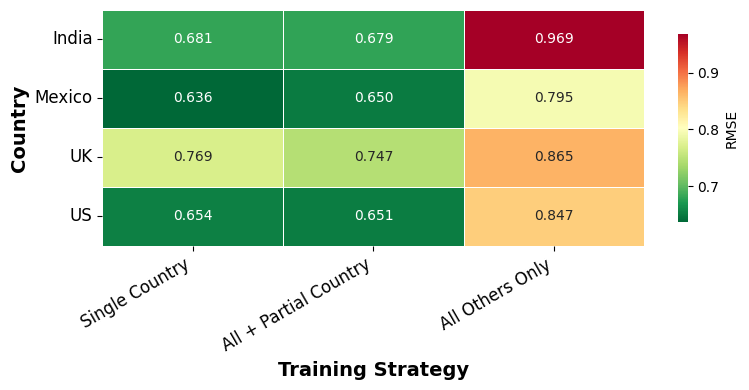

In [71]:
# Create heatmap with improved styling
plt.figure(figsize=(8, 4))
sns.heatmap(rmse_pivot, 
            annot=True, 
            fmt='.3f',
            cmap='RdYlGn_r',
            square=False,
            cbar_kws={'label': 'RMSE', 'shrink': 0.8},
            linewidths=0.5,
            linecolor='white')

plt.xlabel('Training Strategy', fontsize=14, fontweight='bold')
plt.xticks(fontsize=12)
plt.ylabel('Country', fontsize=14, fontweight='bold')
plt.yticks(fontsize=12)
plt.xticks(rotation=30, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Lost RMSE by removing waves

In [ ]:
# Load predictions
predictions_no_india = joblib.load('../data/predictions/predictions_no_india.pkl')
predictions_no_wave5 = joblib.load('../data/predictions/predictions_no_wave5.pkl')
predictions_no_wave45 = joblib.load('../data/predictions/predictions_no_wave45.pkl')
predictions_no_wave345 = joblib.load('../data/predictions/predictions_no_wave345.pkl')

# Load true values
y_test_no_india = pd.read_pickle('../data/processed/y_test_no_india.pkl')
y_test_no_wave5 = pd.read_pickle('../data/processed/y_test_no_wave5.pkl')
y_test_no_wave45 = pd.read_pickle('../data/processed/y_test_no_wave45.pkl')
y_test_no_wave345 = pd.read_pickle('../data/processed/y_test_no_wave345.pkl')

In [ ]:
y_pred_no_india = predictions_no_india['y_ensb_test']
y_pred_no_wave5 = predictions_no_wave5['y_ensb_test']
y_pred_no_wave45 = predictions_no_wave45['y_ensb_test']
y_pred_no_wave345 = predictions_no_wave345['y_ensb_test']

y_pred_no_india['y_true'] = y_test_no_india.values
y_pred_no_wave5['y_true'] = y_test_no_wave5.values
y_pred_no_wave45['y_true'] = y_test_no_wave45.values
y_pred_no_wave345['y_true'] = y_test_no_wave345.values

print(f'no india: {root_mean_squared_error(y_pred_no_india["y_true"], y_pred_no_india["y"]):.3f}')
print(f'no wave 5: {root_mean_squared_error(y_pred_no_wave5["y_true"], y_pred_no_wave5["y"]):.3f}')
print(f'no wave 45: {root_mean_squared_error(y_pred_no_wave45["y_true"], y_pred_no_wave45["y"]):.3f}')
print(f'no wave 345: {root_mean_squared_error(y_pred_no_wave345["y_true"], y_pred_no_wave345["y"]):.3f}')

no india: 0.663
no wave 5: 0.709
no wave 45: 0.735
no wave 345: 0.744


# Fairness Metric for each Model and Specification

In [ ]:
import pandas as pd
from sklearn.metrics import mean_squared_error

def calculate_rmse_by_group(data, group_by, target_col='predicted_score', true_col='composite_score'):
    """
    Calculate RMSE and number of samples for each group.
    
    Args:
        data (pd.DataFrame): Input dataframe
        group_by (str): Column to group by
        target_col (str): Column containing predictions
        true_col (str): Column containing true values
    
    Returns:
        pd.DataFrame: DataFrame with RMSE and sample counts for each group
    """
    # Calculate rmse and number of samples in each group in one dataframe
    rmse = data.groupby(group_by).apply(
        lambda x: root_mean_squared_error(x[target_col], x[true_col]),
        include_groups=False
    )
    num_samples = data.groupby(group_by).size()
    df = pd.concat([rmse, num_samples], axis=1)
    df.columns = ['rmse', 'num_samples']
    return df

def get_fairness_metrics(test_data, protected_score, group_col):
    """
    Calculate fairness metric for a specific group column.
    
    Returns:
        float: Fairness metric value
    """
    rmse_group = calculate_rmse_by_group(test_data, group_col, target_col=protected_score, true_col='y_true')

    def calculate_fairness_metric(rmse_by_group):
        fairness_scores = 1 - ((max(rmse_by_group) - min(rmse_by_group)) / max(rmse_by_group)) 
        return fairness_scores

    fairness_group = calculate_fairness_metric(rmse_group['rmse'])
    return fairness_group

def get_overall_rmse(test_data, pred_col='y_pred', true_col='y_true'):
    """
    Calculate overall RMSE for the entire dataset.
    
    Args:
        test_data (pd.DataFrame): Test data
        pred_col (str): Column containing predictions
        true_col (str): Column containing true values
    
    Returns:
        float: Overall RMSE value
    """
    return root_mean_squared_error(test_data[true_col], test_data[pred_col])

def extract_fairness_metrics_for_all_cols(fair_cols):
    """
    Extract fairness metrics for each column in fair_cols, both from main and fair test data.
    
    Args:
        fair_cols (list): List of columns to calculate fairness metrics for
    
    Returns:
        pd.DataFrame: DataFrame with 'main' and 'fair' columns, rows for each fair_col
    """
    
    # Load main test data
    df_test_main = load_test_data('basic')
    
    # Initialize results dictionary
    results = []
    
    # Calculate fairness metrics for each column
    for col in fair_cols:
        # Calculate fairness metric for main data
        fairness_main = get_fairness_metrics(df_test_main, 'y_pred', col)
        
        # Load fair test data for this column
        df_test_fair = load_test_data(f'fair_{col}')
        
        # Calculate fairness metric for fair data
        fairness_fair = get_fairness_metrics(df_test_fair, 'y_pred', col)
        
        # Store results
        results.append({
            'fair_col': col,
            'main': fairness_main,
            'fair': fairness_fair
        })
    
    # Convert to DataFrame
    fairness_df = pd.DataFrame(results)
    fairness_df.set_index('fair_col', inplace=True)
    
    return fairness_df

def extract_rmse_metrics_for_all_cols(fair_cols):
    """
    Extract overall RMSE metrics for each column in fair_cols, both from main and fair test data.
    
    Args:
        fair_cols (list): List of columns to calculate RMSE metrics for
    
    Returns:
        pd.DataFrame: DataFrame with 'main' and 'fair' columns, rows for each fair_col
    """
    
    # Load main test data
    df_test_main = load_test_data('basic')
    
    # Initialize results dictionary
    results = []
    
    # Calculate RMSE metrics for each column
    for col in fair_cols:
        # Calculate overall RMSE for main data
        rmse_main = get_overall_rmse(df_test_main, 'y_pred', 'y_true')
        
        # Load fair test data for this column
        df_test_fair = load_test_data(f'fair_{col}')
        
        # Calculate overall RMSE for fair data
        rmse_fair = get_overall_rmse(df_test_fair, 'y_pred', 'y_true')
        
        # Store results
        results.append({
            'fair_col': col,
            'main': rmse_main,
            'fair': rmse_fair
        })
    
    # Convert to DataFrame
    rmse_df = pd.DataFrame(results)
    rmse_df.set_index('fair_col', inplace=True)
    
    return rmse_df

# Usage
fair_cols = ['country', 'ragender_2_0', 'raeducl']

# Get fairness metrics
fairness_results = extract_fairness_metrics_for_all_cols(fair_cols)
print("Fairness Metrics:")
print(fairness_results)

# Get RMSE metrics
rmse_results = extract_rmse_metrics_for_all_cols(fair_cols)
print("\nRMSE Metrics:")
print(rmse_results)

Fairness Metrics:
                  main      fair
fair_col                        
country       0.795009  0.823384
ragender_2_0  0.966729  0.996990
raeducl       0.783447  0.875256

RMSE Metrics:
                  main      fair
fair_col                        
country       0.675952  0.717049
ragender_2_0  0.675952  0.739564
raeducl       0.675952  0.762248


# Plot with CI

In [29]:
df_test = load_test_data('basic')

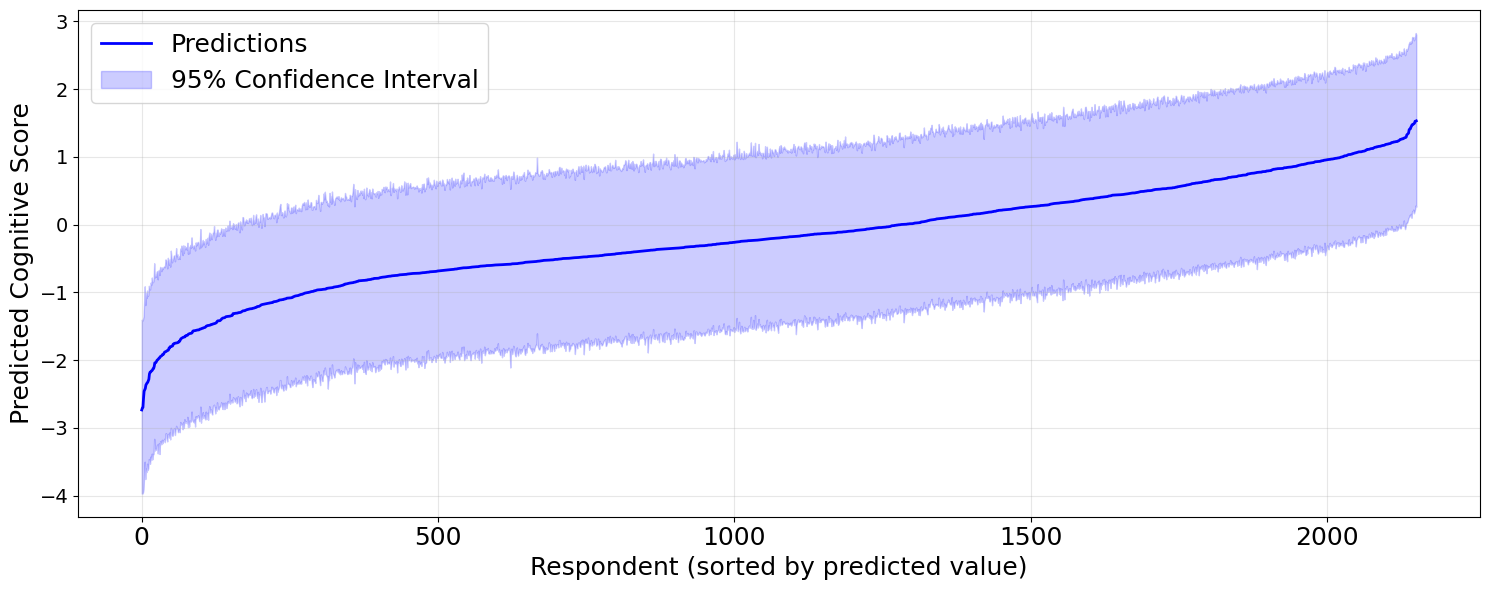

In [39]:
# Sort by predicted values
df_sorted = df_test.sort_values('y_pred')

# Create the plot
plt.figure(figsize=(15, 6))

# Plot the predictions
plt.plot(range(len(df_sorted)), df_sorted['y_pred'], 'b-', label='Predictions', linewidth=2)

# Plot the confidence intervals
plt.fill_between(range(len(df_sorted)), 
                 df_sorted['y_lower'], 
                 df_sorted['y_upper'], 
                 alpha=0.2, 
                 color='blue', 
                 label='95% Confidence Interval')

# Customize the plot
plt.xlabel('Respondent (sorted by predicted value)', fontsize=18)
plt.ylabel('Predicted Cognitive Score', fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=14)
# plt.title('Sorted Predictions with 95% Confidence Intervals', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=18, loc='upper left')

# Show the plot
plt.tight_layout()
plt.show()

# Top-10 and Top-10 negative coefficients.

In [17]:
df_test = load_test_data('basic')
table_variables_type = pd.read_excel('../data/variables/table_variables_type.xlsx')

In [18]:
table_variables_type['SocDet'] = table_variables_type['SocDet'].fillna(0)
table_variables_type['VariableNormalized'] = (
    table_variables_type['Variable'].str.replace('Hw', ''))
table_variables_type['VariableNormalized'] = (
    table_variables_type['VariableNormalized'].str.replace('Rw', ''))
table_variables_type['VariableNormalized'] = (
    table_variables_type['VariableNormalized'].str.lower())

In [ ]:
def regress_shap_on_features(df,
                             shap_col='shap',
                             exclude_cols=None,
                             min_obs=10,
                             confidence_level=0.95):
    """
    Fits a univariate linear regression of SHAP values on each original feature.
    
    Parameters
    ----------
    df : pd.DataFrame
        Original dataframe including SHAP column as a dict.
    shap_col : str
        Name of the column containing SHAP dictionaries.
    exclude_cols : list or None
        Columns to exclude from features. E.g. ['y_true', 'y_pred', 'y_lower', 'y_upper'].
    min_obs : int
        Minimum number of non-missing observations required to fit a regression.
    confidence_level : float
        Confidence level for intervals (default: 0.95 for 95% CI)
    
    Returns
    -------
    pd.DataFrame
        DataFrame with columns: ['feature', 'coefficient', 'ci_lower', 'ci_upper', 'p_value'].
    """

    # Default excluded columns
    if exclude_cols is None:
        exclude_cols = ['y_true', 'y_pred', 'shap', 'y_lower', 'y_upper']
    
    # Ensure shap column is dict
    df_copy = df.copy()
    df_copy[shap_col] = df_copy[shap_col].apply(
        lambda x: ast.literal_eval(x) if isinstance(x, str) else x
    )
    
    # Convert shap dicts to DataFrame
    shap_df = pd.json_normalize(df_copy[shap_col])
    shap_df.index = df_copy.index
    
    # Prepare original features
    X_df = df_copy.drop(columns=exclude_cols, errors='ignore')
    X_df = X_df.select_dtypes(include=['number'])
    
    # Intersect columns
    features = list(set(X_df.columns).intersection(shap_df.columns))
    
    results = []
    
    for feature in features:
        X_feat = X_df[feature]
        shap_feat = shap_df[feature]
        
        # Drop missing
        mask = X_feat.notnull() & shap_feat.notnull()
        if mask.sum() < min_obs:
            continue
        
        X_clean = X_feat[mask]
        y_clean = shap_feat[mask]
        
        # Add constant
        X_reg = sm.add_constant(X_clean)
        
        model = sm.OLS(y_clean, X_reg).fit()
        
        # Get coefficient and its confidence interval
        slope = model.params.get(feature, float('nan'))
        ci = model.conf_int(alpha=1-confidence_level).loc[feature]
        p_value = model.pvalues.get(feature, float('nan'))
        
        results.append({
            'feature': feature,
            'coefficient': slope,
            'ci_lower': ci[0],
            'ci_upper': ci[1],
            'p_value': p_value,
            'n_obs': mask.sum()  # Added number of observations
        })
    
    results_df = pd.DataFrame(results)
    
    # Sort by absolute coefficient value
    results_df = results_df.sort_values('coefficient', key=abs, ascending=False)
    
    return results_df

In [22]:
df_feat_coef = regress_shap_on_features(df_test)

In [23]:
df_feat_coef['feature_normalized'] = df_feat_coef['feature'].str.replace(r'[hr]\d', '', regex=True)
df_feat_coef['feature_normalized'] = df_feat_coef['feature_normalized'].str.split('_').str[0]

df_feat_coef = df_feat_coef.merge(
    table_variables_type, left_on='feature_normalized', right_on='VariableNormalized', how='left')

# Drop rows with feature ending with '_nan'
df_feat_coef = df_feat_coef[~df_feat_coef['feature'].str.endswith('_nan')]

# Select only SocDet features
df_feat_coef_socdet = df_feat_coef[df_feat_coef['SocDet'] == 1]

# Top 10 and bottom 10 features by coefficient
top_10_socdet = df_feat_coef_socdet.sort_values(by='coefficient', ascending=False).head(10)
bottom_10_socdet = df_feat_coef_socdet.sort_values(by='coefficient', ascending=True).head(10)

In [24]:
def format_coefficient_table(df_coef: pd.DataFrame,
                           coef_col: str = 'coefficient',
                           ci_lower_col: str = 'ci_lower',
                           ci_upper_col: str = 'ci_upper',
                           feature_col: str = 'feature',
                           description_col: str = 'Description',
                           decimals: int = 3) -> pd.DataFrame:
    """
    Create a formatted table with feature descriptions and confidence intervals.
    
    Parameters
    ----------
    df_coef : pd.DataFrame
        DataFrame containing coefficients, CIs, and descriptions
    coef_col : str
        Name of column containing coefficients
    ci_lower_col : str
        Name of column containing lower confidence interval bounds
    ci_upper_col : str
        Name of column containing upper confidence interval bounds
    feature_col : str
        Name of column containing feature names
    description_col : str
        Name of column containing feature descriptions
    decimals : int
        Number of decimal places for numeric values
    
    Returns
    -------
    pd.DataFrame
        Formatted table with features, descriptions, and confidence intervals
    """
    # Create new DataFrame with selected columns
    table = df_coef[[feature_col, description_col, coef_col, ci_lower_col, ci_upper_col]].copy()
    
    # Format numeric columns
    table[coef_col] = table[coef_col].round(decimals)
    table[ci_lower_col] = table[ci_lower_col].round(decimals)
    table[ci_upper_col] = table[ci_upper_col].round(decimals)
    
    # Create CI column
    table['95% CI'] = table.apply(
        lambda row: f"[{row[ci_lower_col]}, {row[ci_upper_col]}]",
        axis=1
    )
    
    # Reorder columns and rename
    final_table = table[[
        feature_col,
        description_col,
        coef_col,
        '95% CI'
    ]].rename(columns={
        feature_col: 'Feature',
        description_col: 'Description',
        coef_col: 'Coefficient'
    })
    
    return final_table

In [25]:
top_10_socdet_formatted = format_coefficient_table(top_10_socdet)
bottom_10_socdet_formatted = format_coefficient_table(bottom_10_socdet)

In [27]:
top_10_socdet_formatted

,Feature,Description,Coefficient,95% CI
0,raeducl,Harmonized education level,0.484,"[0.478, 0.491]"
22,r4notsmrt_2_0,People act as if the respondent is not smart,0.013,"[0.013, 0.013]"
29,r5peninc_1_0,Whether currently receiving private pension pa...,0.011,"[0.01, 0.011]"
31,r3mstath_2_0,Self-reported marital status,0.011,"[0.01, 0.011]"
43,r5slfemp_1_0,Whether self-employed,0.009,"[0.009, 0.009]"
45,r5cantril,Cantril ladder rating (10-point scale),0.009,"[0.008, 0.01]"
48,r4lsrspct_2_0,Treated with less courtesy or respect,0.008,"[0.008, 0.009]"
50,r5momliv_1_0,Mother Alive,0.008,"[0.008, 0.008]"
53,r5prtrmt_3_0,Received poorer service from doctors or hospit...,0.008,"[0.008, 0.008]"
67,r5unemp_1_0,Whether unemployed,0.006,"[0.006, 0.006]"


In [72]:
bottom_10_socdet_formatted

,Feature,Description,Coefficient,95% CI
3,h5rural_1_0,Lives in rural or urban,-0.111,"[-0.113, -0.109]"
12,h4rural_1_0,Lives in rural or urban,-0.021,"[-0.022, -0.021]"
13,r4fsupport,Respondent lack of friends support summary mea...,-0.021,"[-0.023, -0.019]"
15,r2lnlys,Loneliness summary mean score (4-items),-0.015,"[-0.016, -0.014]"
17,r5mstath_3_0,Self-reported marital status,-0.014,"[-0.015, -0.014]"
18,r1fsupport,Respondent lack of friends support summary mea...,-0.013,"[-0.015, -0.012]"
27,r4prsrvc_5_0,Received poorer service than other people,-0.012,"[-0.012, -0.011]"
28,r1lnlys,Loneliness summary mean score (4-items),-0.011,"[-0.012, -0.011]"
32,r3fsupport,Respondent lack of friends support summary mea...,-0.010,"[-0.011, -0.01]"
36,r2fsupport,Respondent lack of friends support summary mea...,-0.010,"[-0.011, -0.009]"


In [215]:
top_10_socdet_formatted.to_excel('top_10_socdet_formatted.xlsx', index=False)
bottom_10_socdet_formatted.to_excel('bottom_10_socdet_formatted.xlsx', index=False)